In [1]:

import qiskit 
import numpy as np
import matplotlib.pyplot as plt
import random
%load_ext autoreload
%autoreload 2
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit import qpy

from qoop.evolution import normalizer
from qoop.evolution.environment_synthesis import MetadataSynthesis
from qoop.evolution.generator import by_num_rotations,by_num_rotations_and_cnot
from qoop.evolution.environment import EEnvironment
from qoop.evolution.crossover import onepoint
from qoop.evolution.mutate import bitflip_mutate_with_normalizer
from qoop.evolution.divider import by_num_cnot
from qoop.evolution.threshold import synthesis_threshold
from qoop.backend.constant import operations_with_rotations
from qoop.evolution import divider
from qoop.backend.utilities import load_circuit


In [2]:
def generate_data(n_samples,n_features,centers, random_state):
    X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, random_state=random_state)
    y = 2 * y - 1  # Convert labels to {-1, +1} for compatibility with QSVC
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

X_train,X_test,y_train, y_test = generate_data(n_samples=120, n_features=4, centers=2, random_state=41)
feature_dimension = 2
FeatureM = ZZFeatureMap(feature_dimension=4, reps=1)

In [3]:
def load_circuits(fitness_levels):
    circuits = []
    for fitness in range(1, fitness_levels+1):
        print(fitness)
        file_name = f'4qubits_FM{fitness}_fitness_2024-12-12/best_circuit.qpy'
        with open(file_name, 'rb') as fd:
            circuit = qpy.load(fd)[0]
            print(circuit)  # Print if needed
            circuits.append(circuit)
    return circuits

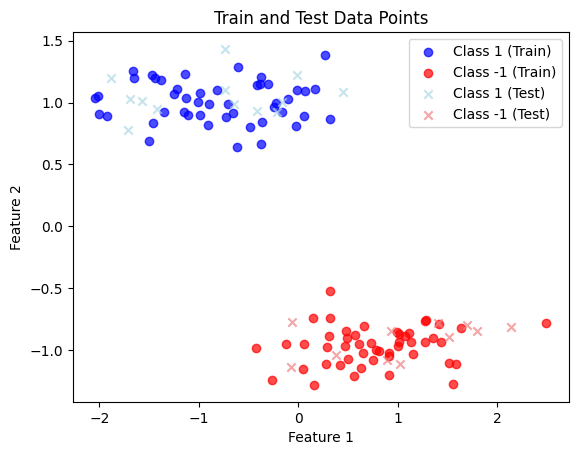

In [4]:
plt.figure()  # Create a new figure
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='Class 1 (Train)', alpha=0.7)
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], color='red', label='Class -1 (Train)', alpha=0.7)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='lightblue', label='Class 1 (Test)', marker='x', alpha=0.7)
plt.scatter(X_test[y_test == -1, 0], X_test[y_test == -1, 1], color='lightcoral', label='Class -1 (Test)', marker='x', alpha=0.7)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Train and Test Data Points')
plt.legend()

In [5]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Load Wine Dataset
wine = load_wine()
X = wine.data
y = wine.target

# Lấy dữ liệu chỉ gồm lớp 0 và 1
X = X[y != 2]
y = y[y != 2]

# Chia train-test
Xw_train, Xw_test, yw_train, yw_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
Xw_train = scaler.fit_transform(Xw_train)
Xw_test = scaler.transform(Xw_test)

# Áp dụng PCA
pca = PCA(n_components=4)
Xw_train = pca.fit_transform(Xw_train)
Xw_test = pca.transform(Xw_test)


# Thiết lập tùy chọn hiển thị của NumPy
np.set_printoptions(suppress=True)  # precision=3: 3 chữ số thập phân, suppress=True: bỏ ký hiệu khoa học


def train_qsvm_with_wine(quantum_circuit):
    quantum_kernel = FidelityQuantumKernel(feature_map=quantum_circuit)
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(Xw_train, yw_train)
    y_pred = qsvc.predict(Xw_test)
    accuracy = accuracy_score(yw_test, y_pred)

    return accuracy




In [ ]:
# Define the metadata
# When increase all the can change then there is a error list index out of range
env_metadata = MetadataSynthesis(
    num_qubits=4,            # Number of qubits
    num_cnot=4,              # Number of CNOT gates
    num_rx=1,                # Number of RX gates # Can't change
    num_ry=1,                # Number of RY gates # Can't change
    num_rz=2,                # Number of RZ gates # Can't change
    depth=4,                 # Depth of the circuit # Can't change this with num_circuit, num_generation
    num_circuit=5,           # Number of circuits in the population
    num_generation=5,       # Number of generations 
    prob_mutate=0.01         # Mutation probability
)

# Define the environment
env = EEnvironment(
    metadata=env_metadata,
    fitness_func=train_qsvm_with_wine,
    generator_func=by_num_rotations_and_cnot,  # Use the new generator function
    crossover_func=onepoint(
        divider.by_num_rotation_gate(int((env_metadata.num_qubits)/ 2)),
        normalizer.by_num_rotation_gate(env_metadata.num_qubits)
    ),
    mutate_func=bitflip_mutate_with_normalizer(operations_with_rotations, 
                                               normalizer_func=normalizer.by_num_rotation_gate(env_metadata.num_qubits)),
    threshold_func=synthesis_threshold
)

# Run the evolution process

env.evol(verbose=True, mode="noparallel")


Step:   0%|          | 0/5 [00:00<?, ?it/s]

Initialize list of circuit ...
Start evol progress ...
Running at generation 1


Step:  25%|██▌       | 1/4 [02:18<06:54, 138.00s/it]


[0.9231 0.8077 0.8846 0.8077 0.7692]
Saving circuit ...
Saving circuit ...


IndexError: list index out of range

In [ ]:
clf = SVC( gamma=0.877551020408163, kernel="rbf").fit(X_train, y_train)
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))
# Print classification report
print("Training Classification Report:")
print(classification_report(y_train, train_pred))

print("\nTesting Classification Report:")
print(classification_report(y_test, test_pred))

1.0
1.0
Training Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        47

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96


Testing Classification Report:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        13

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

